<a href="https://colab.research.google.com/github/apadkavyrava/Contextual-text-parsing-/blob/master/Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!python -m spacy download en_core_web_lg
# uncomment above if lg model not found, with fresh runtime etc
import spacy
import pandas as pd
data_raw = pd.read_csv('Data_vector.csv')
nlp = spacy.load("en_core_web_lg")
data = data_raw['Words']
tokenised = [nlp(row) for row in data]
vectors = [doc.vector for doc in tokenised]
vectors_df = pd.DataFrame(vectors)
out= data_raw.join(vectors_df)
out.to_csv('Ready_to_use')


(0.0, 100.0)

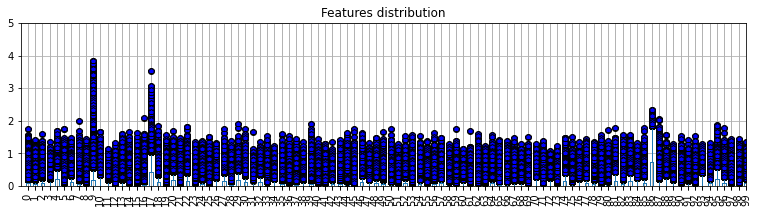

In [0]:
#made sure that the features were normalised
import matplotlib.pyplot as plt
data = pd.read_csv('Ready_to_use')
#see the distribution
X  = data.iloc[:, 3:]
plt.figure(figsize = (13,3))
X.boxplot(X.columns.name, rot=90)
plt.title("Features distribution")
outliers = dict(markerfacecolor='b', marker='p')
ax= X.boxplot(X.columns.name, rot=90, flierprops=outliers)
plt.ylim([0, 5])  
plt.xlim([0,100])


In [0]:
#split the data
from sklearn.model_selection import train_test_split
y = data['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify =y, random_state =42)
X_cv, X_test_cv, y_cv, y_test_cv = train_test_split(X, y, test_size = 0.1, stratify = y, random_state =42)


In [0]:
#Also I would like to compare which model works better - with all features or only with relevant
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
num_f = 4
model =  LogisticRegression()
run_model = RFE(model, num_f)
run_model.fit(X, y)
print("Features  ranking:", run_model.ranking_)
score_m = run_model.score(X, y)
print("Features selected: %f"  % score_m.mean())
features_name = np.array(features.columns)
print("Most efficient columns: %s" % features_name[run_model.support_])
#didn't converge

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
classifier = RandomForestClassifier(n_estimators = 20, criterion = 'entropy', random_state = 42)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy_score(y_test, y_pred)
print("Sore {}".format(accuracy_score(y_pred, y_test)))
print(classification_report(y_test, y_pred))

Sore 0.91669414221343
              precision    recall  f1-score   support

        DATE       1.00      0.91      0.95       142
         LOC       0.91      0.99      0.95      7191
         ORG       0.93      0.62      0.74      1005
         OTH       0.90      0.77      0.83       427
     PRODUCT       0.90      0.42      0.57       185
         RAN       1.00      0.21      0.34       149

    accuracy                           0.92      9099
   macro avg       0.94      0.65      0.73      9099
weighted avg       0.92      0.92      0.91      9099



In [0]:
#make sure that model is stable
from sklearn import metrics
from sklearn.model_selection import cross_val_score

print(X.shape)
classifier = RandomForestClassifier(n_estimators = 20, criterion = 'entropy', random_state = 42)
cros_val = cross_val_score(classifier, X_train, y_train, cv=5)
print(cros_val)

(30330, 300)
[0.91264422 0.9149788  0.90932642 0.91780499 0.91427226]


In [0]:
#tried NN
import keras

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

LB=LabelBinarizer()
LB.fit(y_train)

y_cat = LB.transform(y_train)
model = Sequential()
model.add(Dense(60, input_dim=300, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_cat, epochs=40, batch_size=64)


Epoch 1/40
21231/21231 [==============================] - 1s 40us/step - loss: 0.6039 - accuracy: 0.8725
Epoch 2/40
21231/21231 [==============================] - 1s 34us/step - loss: 0.2757 - accuracy: 0.9297
Epoch 3/40
21231/21231 [==============================] - 1s 35us/step - loss: 0.2451 - accuracy: 0.9383
Epoch 4/40
21231/21231 [==============================] - 1s 34us/step - loss: 0.2278 - accuracy: 0.9448
Epoch 5/40
21231/21231 [==============================] - 1s 34us/step - loss: 0.2098 - accuracy: 0.9484
Epoch 6/40
21231/21231 [==============================] - 1s 34us/step - loss: 0.2012 - accuracy: 0.9506
Epoch 7/40
21231/21231 [==============================] - 1s 35us/step - loss: 0.1932 - accuracy: 0.9540
Epoch 8/40
21231/21231 [==============================] - 1s 34us/step - loss: 0.1847 - accuracy: 0.9574
Epoch 9/40
21231/21231 [==============================] - 1s 36us/step - loss: 0.1800 - accuracy: 0.9581
Epoch 10/40
21231/21231 [==============================

In [0]:
#check the accuracy and have a look what label do we have
from sklearn import metrics
print(LB.classes_)
y_test_cat = LB.transform(y_test)
y_pred_cat = model.predict(X_test)
y_pred = LB.inverse_transform(y_pred_cat)
print(metrics.classification_report(y_test, y_pred))
model.save('basic_model.h5')

['DATE' 'LOC' 'ORG' 'OTH' 'PRODUCT' 'RAN']
              precision    recall  f1-score   support

        DATE       1.00      0.92      0.96       142
         LOC       0.96      0.99      0.98      7191
         ORG       0.98      0.86      0.91      1005
         OTH       0.95      0.95      0.95       427
     PRODUCT       0.89      0.89      0.89       185
         RAN       1.00      0.26      0.41       149

    accuracy                           0.96      9099
   macro avg       0.96      0.81      0.85      9099
weighted avg       0.96      0.96      0.96      9099



In [0]:
import spacy
import pandas as pd
nlp = spacy.load("en_core_web_lg")

def classify(text):
  tokenised = nlp(text)
  vectors = [tokenised.vector]
  vectors_df = pd.DataFrame(vectors)
  y_pred_cat = model.predict(vectors_df)
  y_pred = LB.inverse_transform(y_pred_cat)
  return y_pred

classify("beer glass")




array(['PRODUCT'], dtype='<U7')

In [0]:
# k-fold cross validation
# drop out

import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)
cvscores = []
for train_loc, test_loc in kfold.split(X_cv, y_cv):
  X_train_cv = X_cv.iloc[train_loc]
  y_train_cv = y_cv.iloc[train_loc]
  X_test_cv = X_cv.iloc[test_loc]
  y_test_cv = y_cv.iloc[test_loc]

  LB=LabelBinarizer()
  LB.fit(y_train_cv)
  
  y_cat = LB.transform(y_train_cv)
  model = Sequential()
  model.add(Dense(60, input_dim=300, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(20, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(6, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.fit(X_train_cv, y_cat, epochs=40, batch_size=64)
  
  # evaluate performance
  y_test_cat = LB.transform(y_test_cv)
  scores = model.evaluate(X_test_cv, y_test_cat, verbose=0)
  cvscores.append(scores[1])

print('CV scores mean:', np.mean(cvscores))
print('CV scores stdev:', np.stdev(cvscores))



In [0]:
import numpy as np

print('CV scores mean:', np.mean(cvscores))
print('CV scores stdev:', np.std(cvscores))

CV scores mean: 0.9448659777641296
CV scores stdev: 0.0023356329616429253


In [0]:
#standalone file classifier.py

import spacy
import pandas as pd
import keras
from keras.models import load_model
from sklearn.preprocessing import LabelBinarizer

#if below doesn't work install lg model:
#!python -m spacy download en_core_web_lg
nlp = spacy.load("en_core_web_lg")

LB = LabelBinarizer()
LB.fit(['DATE', 'LOC', 'ORG', 'OTH', 'PRODUCT', 'RAN'])

def classify(text):
  model = load_model('basic_model.h5')
  tokenised = nlp(text)
  vectors = [tokenised.vector]
  vectors_df = pd.DataFrame(vectors)
  y_pred_cat = model.predict(vectors_df)
  y_pred = LB.inverse_transform(y_pred_cat)
  return y_pred

classify("beijing")

array(['LOC'], dtype='<U7')